<a href="https://colab.research.google.com/github/oleg0x/Python_libraries_examples/blob/main/nn_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
# 1. Generate synthetic data
X, y = datasets.make_classification(n_samples=1000, n_features=20, n_classes=2, n_informative=15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

# Create datasets and dataloaders
train_data = TensorDataset(X_train, y_train)    # Combine X_train and y_train into a single dataset object
test_data = TensorDataset(X_test, y_test)       # Combine X_train and y_train into a single dataset object
batch_size = 64                                 # How many samples will be processed at once
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)


In [ ]:
# 2. Define the neural network architecture
# Two hidden layers with ReLU activation and dropout for regularization
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)          # Fully connected (dense) layer 1
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)        # Fully connected (dense) layer 2
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_size2, output_size)         # Fully connected (dense) layer 3

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return out

# Initialize the model
input_size = X_train.shape[1]
hidden_size1 = 64
hidden_size2 = 32
output_size = 2                 # Binary classification

model = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)


In [ ]:
# 3. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 4. Training loop
num_epochs = 40
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:     # Each 'inputs' is a batch of size batch_size=64
        optimizer.zero_grad()               # Zero gradients
        outputs = model(inputs)             # Forward pass
        loss = criterion(outputs, labels)
        loss.backward()                     # Backward pass
        optimizer.step()                    # Params update

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluation phase
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
            f'train loss: {train_loss:.4f}, train accuracy: {train_accuracy:.2f}%, '
            f'test loss: {test_loss:.4f}, test accuracy: {test_accuracy:.2f}%')


Epoch [5/40], train loss: 0.4220, train accuracy: 83.38%, test loss: 0.3786, test accuracy: 83.50%
Epoch [10/40], train loss: 0.2684, train accuracy: 88.62%, test loss: 0.2629, test accuracy: 87.00%
Epoch [15/40], train loss: 0.1996, train accuracy: 92.62%, test loss: 0.1963, test accuracy: 87.50%
Epoch [20/40], train loss: 0.1643, train accuracy: 94.00%, test loss: 0.1615, test accuracy: 92.00%
Epoch [25/40], train loss: 0.1284, train accuracy: 95.62%, test loss: 0.1428, test accuracy: 93.00%
Epoch [30/40], train loss: 0.1152, train accuracy: 95.88%, test loss: 0.1309, test accuracy: 93.00%
Epoch [35/40], train loss: 0.0982, train accuracy: 96.25%, test loss: 0.1294, test accuracy: 93.50%
Epoch [40/40], train loss: 0.0892, train accuracy: 96.38%, test loss: 0.1212, test accuracy: 94.50%


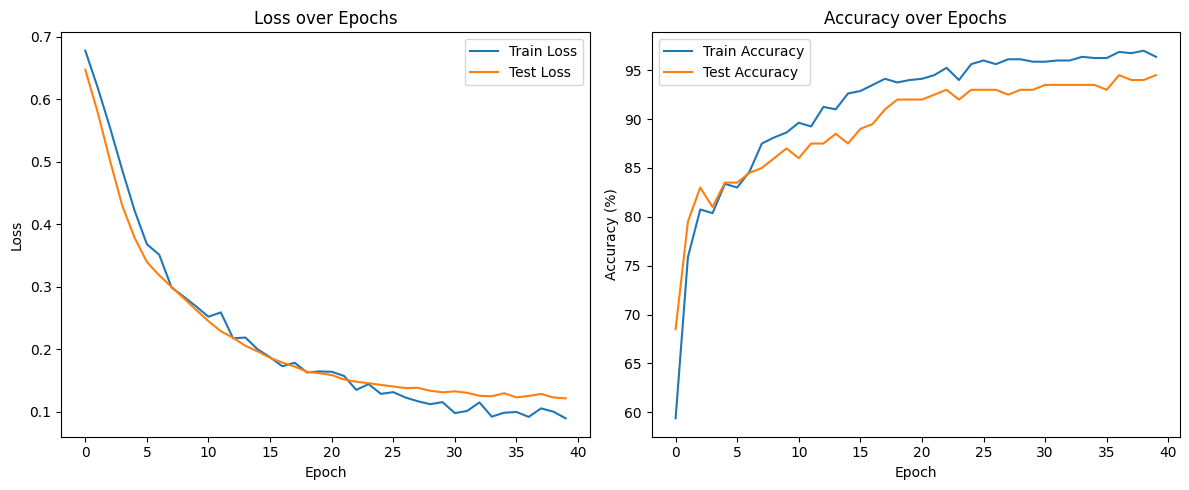

In [ ]:
# 5. Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy over Epochs')

plt.tight_layout()
plt.show()

In [ ]:
# 6. Save the model
torch.save(model.state_dict(), 'model.pth')